# Transformer

`subsec_cnn-rnn-self-attention`中比较了卷积神经网络（CNN）、循环神经网络（RNN）和自注意力（self-attention）。值得注意的是，自注意力同时具有并行计算和最短的最大路径长度这两个优势。因此，使用自注意力来设计深度架构是很有吸引力的。

**对比之前仍然依赖循环神经网络实现输入表示的自注意力模型**`Cheng.Dong.Lapata.2016`，
**Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层**`Vaswani.Shazeer.Parmar.ea.2017`。

尽管Transformer最初是应用于在文本数据上的序列到序列学习，但现在已经推广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## 模型

Transformer作为编码器－解码器架构的一个实例，其整体架构图在`fig_transformer`中展示。正如所见到的，Transformer是由编码器和解码器组成的。与`fig_s2s_attention_details`中基于Bahdanau注意力实现的序列到序列的学习相比，Transformer的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的*嵌入*（embedding）表示将加上*位置编码*（positional encoding），再分别输入到编码器和解码器中。

![transformer架构](../img/transformer.svg)

图`fig_transformer`中概述了Transformer的架构。

从宏观角度来看，Transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为$\mathrm{sublayer}$）。第一个子层是*多头自注意力*（multi-head self-attention）汇聚；第二个子层是*基于位置的前馈网络*（positionwise feed-forward network）。

具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受`sec_resnet`中残差网络的启发，每个子层都采用了*残差连接*（residual connection）。在Transformer中，对于序列中任何位置的任何输入$\mathbf{x} \in \mathbb{R}^d$，都要求满足$\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足$\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。在残差连接的加法计算之后，紧接着应用*层规范化*（layer normalization）`Ba.Kiros.Hinton.2016`。因此，输入序列对应的每个位置，Transformer编码器都将输出一个$d$维表示向量。

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为*编码器－解码器注意力*（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种*掩蔽*（masked）注意力保留了*自回归*（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

在此之前已经描述并实现了基于缩放点积多头注意力`sec_multihead-attention`和位置编码`subsec_positional-encoding`。接下来将实现Transformer模型的剩余部分。

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 基于位置的前馈网络

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是*基于位置的*（positionwise）的原因。在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。

PositionWiseFFN 只在 X 的特征维度上做变换，相较于普通的 MLP，其最大特征可能是输入 X 由二维变成了三维。

In [2]:
#@save
class PositionWiseFFN(nn.Module):  # Position-Wise Feed-Forward Network
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        # ffn_num_input: 输入的特征维度大小（例如 Transformer 中每个位置的嵌入向量维度）
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        # X: 输入的特征，形状为（批量大小，序列长度，特征维度）
        # 只在 X 的特征维度上做变换
        return self.dense2(self.relu(self.dense1(X)))

**下面的例子显示，改变张量的最里层维度的尺寸，会改变成基于位置的前馈网络的输出尺寸。**

因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。

In [5]:
# ffn_num_input = 4
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()

# 输入：（批量大小，序列长度，特征维度）
print('inpput shape:', torch.ones((2, 3, 4)).shape)

# 输出：（批量大小，序列长度，输出维度）
print('output shape:', ffn(torch.ones((2, 3, 4))).shape)

inpput shape: torch.Size([2, 3, 4])
output shape: torch.Size([2, 3, 8])


## 残差连接和层规范化

现在让我们关注`fig_transformer`中的*加法和规范化*（add&norm）组件。正如在本节开头所述，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。

`sec_batch_norm`中解释了在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

BatchNorm 是对一个 batch size 样本内的每个特征 **分别** 做归一化，LayerNorm 是 **分别** 对每个样本的所有特征做归一化。

以下代码对比不同维度的层规范化和批量规范化的效果。

In [6]:
# 层归一化是沿着输入的特征维度进行归一化的。它对每个输入样本的每个特征做归一化处理，而不是跨样本进行计算。
# 在这种情况下，每一行的特征值会根据这一行的均值和方差进行归一化处理。
ln = nn.LayerNorm(2)  # 输入维度为 2

# 批归一化是沿着批次维度进行归一化的。它对每个特征跨多个样本计算均值和方差，统一进行归一化。
# 这意味着每列的数值会根据该列中所有样本的均值和方差进行归一化处理。
bn = nn.BatchNorm1d(2)

# 假设有两个样本，每个样本有两个特征
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)

# 在训练模式下计算 X 层归一化和批归一化的结果
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以使用残差连接和层规范化来实现`AddNorm`类。暂退法也被作为正则化方法使用。

In [7]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)  # 随机失活，防止过拟合
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

**残差连接要求两个输入的形状相同，以便加法操作后输出张量的形状相同。**

In [8]:
# normalized_shape 设置为 [3, 4]，表示输入张量的形状为 (batch_size, 3, 4)
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()

add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

### BatchNorm和LayerNorm的区别

BatchNorm 是对一个 batch size 样本内的每个特征 **分别** 做归一化，LayerNorm 是 **分别** 对每个样本的所有特征做归一化。

**BN 抹杀了不同特征之间的大小关系，但是保留了不同样本间的大小关系；LN 抹杀了不同样本间的大小关系，但是保留了一个样本内不同特征之间的大小关系。**

形象的例子：
BatchNorm 是对一个 batch 里不同的图片的同一个特征进行 normalization；
LayerNorm 是对一个 batch 里的一个句子的所有词元向量进行归一化。

![BN-LN](../img/BN-LN.jpg)

#### BatchNorm

- **BatchNorm（批量归一化）**: 归一化是对**每个 mini-batch** 内的不同样本（跨样本）进行的，也就是沿着 batch 维度进行操作。具体来说，它对每一个 mini-batch 中的所有样本的特征在同一个通道（feature map）上进行归一化。

- 如果输入是形状为 $(B, C, H, W)$ 的四维数据（比如卷积网络中的图像数据），那么 BatchNorm 对维度 $B$ 上的数据进行归一化，即对每个通道 $C$ 的所有像素进行归一化。

- **BN 抹杀了不同特征之间的大小关系，但是保留了不同样本间的大小关系。**

- **更适用于卷积神经网络（CNN）和全连接网络（MLP）**。因为 CNN 中每个 mini-batch 中的样本通常比较相似，且 CNN 的输入具有固定大小。BatchNorm 在这种情况下可以稳定训练并加速收敛。

- 依赖 mini-batch 大小。较小的 batch size 会导致估计均值和方差不稳定，进而影响模型的表现。

#### LayerNorm

- **LayerNorm（层归一化）**: 归一化是对**每个样本的特征维度**进行的。它对每个样本（不跨样本）独立地进行归一化，归一化是针对特征维度的。

- 对于输入 $(B, C, H, W)$，它会在 $C$, $H$, $W$ 维度上进行归一化，而不依赖 batch 大小。

- **LN 抹杀了不同样本间的大小关系，但是保留了一个样本内不同特征之间的大小关系。**

- **更适合于循环神经网络（RNN）和自注意力机制**，尤其是输入长度或 mini-batch 大小可能变化的场景，比如 NLP 任务中的 Transformer 模型。LayerNorm 使得每个样本独立归一化，因此在不同样本大小或序列长度时更为稳定。

- 与 batch size 无关，适合于小 batch 或 batch size 为 1 的场景。

### 为什么使用LayerNorm

首先 RNN 或 Transformer 解决的是序列问题，**一个存在的问题是不同样本的序列长度不一致**，而 Batch Normalization 需要对不同样本的同一位置特征进行标准化处理，所以无法应用；当然，输入的序列都要做 padding 补齐操作，但是补齐的位置填充的都是 0，这些位置都是无意义的，此时的标准化也就没有意义了。

其次上面说到，BN 抹杀了一个样本内不同特征之间的大小关系；LN 是保留了一个样本内不同特征之间的大小关系，这对 NLP 任务是至关重要的。对于 NLP 或者序列任务来说，一条样本的不同特征，其实就是时序上的变化，这正是需要学习的东西自然不能做归一化抹杀，所以要用 LN。

## 编码器

有了组成Transformer编码器的基础组件，现在可以先实现编码器中的一个层。
下面的`EncoderBlock`类包含两个子层：

**多头自注意力 和 基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。**

In [9]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        # 多头注意力
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        # Add & Norm 1
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 基于位置的前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        # Add & Norm 2
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        # 注：self.attention 参数为 queries, keys, values, valid_lens；因为是 self-attention，所以 keys, values 与 queries 相同
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

正如从代码中所看到的，**Transformer编码器中的任何层都不会改变其输入的形状（batch_size, seq_len, hidden_size）。**

因为残差连接要求两个输入的形状相同，以便加法操作后输出张量的形状相同。

In [10]:
# X 形状为 (batch_size, num_steps, embed_size)，是 encoder_blk 的输入（与 encoder 输入维度不同）
# embed_size = query_size = key_size = value_size = ffn_num_hiddens = num_hiddens
X = torch.ones((2, 100, 24))

valid_lens = torch.tensor([3, 2])

# norm_shape: [num_steps, embed_size] 设置为 [100, 24]
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()

encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

下面实现的Transformer编码器的代码中，堆叠了`num_layers`个`EncoderBlock`类的实例。
由于这里使用的是值范围在 $-1$ 和 $1$ 之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

In [11]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 位置编码层
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 使用 nn.Sequential 作为容器来存储多个 EncoderBlock（编码器块）
        self.blks = nn.Sequential()

        # i 代表第 i 个编码器块
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # X 形状为 (batch_size, num_steps)，代表原始文本，经过 embedding 层才会变为 (batch_size, num_steps, num_hiddens)
        # 因位置编码值在 -1 和 1 之间，故嵌入值乘以嵌入维度的平方根进行缩放，再与位置编码相加
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # 初始化存储注意力权重的列表 self.attention_weights，长度等于编码器块的数量
        self.attention_weights = [None] * len(self.blks)

        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

下面我们指定了超参数来创建一个两层的Transformer编码器。

**Transformer编码器输出的形状是（批量大小，时间步数目），代表原始文本序列；经过 embedding 层后，才会变为 （批量大小，时间步数目，`num_hiddens`）。**

**故Transformer编码器输出的形状是（批量大小，时间步数目，`num_hiddens`）。**

In [14]:
# norm_shape: [num_steps, embed_size] 设置为 [100, 24]
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()

# encoder 输入为 (batch_size, num_steps)，其中每个元素是一个词汇在词汇表中的索引，代表原始文本序列
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

# 输出形状为 (batch_size, num_steps, num_hiddens)

torch.Size([2, 100, 24])

## 解码器

如`fig_transformer`所示，Transformer解码器也是由多个相同的层组成。
在`DecoderBlock`类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于*序列到序列模型*（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数`dec_valid_lens`，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。

In [15]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        # i 代表第 i 个解码器块
        self.i = i
        # 多头注意力 1（掩蔽多头注意力），用于计算解码器的自注意力
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        # Add & Norm 1
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 多头注意力 2，用于计算编计算解码器对编码器输出的注意力
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        # Add & Norm 2
        self.addnorm2 = AddNorm(norm_shape, dropout)
        # 基于位置的前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        # Add & Norm 3
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        # state[0] 编码器的输出；state[1] 有效长度；state[2] 解码器的历史输出
        enc_outputs, enc_valid_lens = state[0], state[1]

        # 训练阶段，输出序列的所有词元都在同一时间处理，因此 state[2][self.i] 初始化为 None
        if state[2][self.i] is None:
            key_values = X
        # 预测阶段，输出序列是通过词元一个接着一个解码的，因此 state[2][self.i] 包含着直到当前时间步第 i 个块解码的输出表示
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)

        state[2][self.i] = key_values

        # 训练阶段，dec_valid_lens 包含从 1 到 num_steps 的值，用来约束解码器的自注意力
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens 形状为 (batch_size, num_steps)，其中每一行是 [1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        # 测试阶段，因为是逐步生成的，所有词元都可以参与注意力机制，故不需要 dec_valid_lens 约束
        else:
            dec_valid_lens = None

        # 自注意力（掩蔽多头注意力）
        # key_values 是 X 的历史累积值，dec_valid_lens 是自注意力的约束，防止模型“偷看”未来的词元
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)

        # 编码器－解码器注意力
        # 即解码器在生成每个词元时，考虑编码器的输出信息 enc_outputs；enc_valid_lens 则用于剔除填充词元
        # enc_outputs 形状为 (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)

        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，编码器和解码器的特征维度都是`num_hiddens`。

In [12]:
# norm_shape: [num_steps, embed_size] 设置为 [100, 24]
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()

# encoder_blk 的输入为 (batch_size, num_steps, embed_size)
# 注：encoder_blk 与 encoder 的输入维度不同
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]

# decoder_blk 的输入为 (batch_size, num_steps, num_hiddens)；注：这里 num_hiddens = embed_size
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

现在我们构建了由`num_layers`个`DecoderBlock`实例组成的完整的Transformer解码器。最后，通过一个全连接层计算所有`vocab_size`个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要。

In [16]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        # num_layers 代表解码器层的数量
        self.num_layers = num_layers

        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 位置编码层
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 使用 nn.Sequential 作为容器来存储多个 DecoderBlock（编码器块）
        self.blks = nn.Sequential()
        
        # i 代表第 i 个解码器块
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))  # 此时 i 作为参数传入 DecoderBlock ！
        
        # 线性层，将隐藏层的输出映射回词汇表的大小
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # [None] * self.num_layers：用于解码阶段逐步积累的状态，初始化为 None；num_layers 代表解码器层的数量
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        # X 形状为 (batch_size, num_steps)，代表原始文本，经过 embedding 层才会变为 (batch_size, num_steps, num_hiddens)
        # 因位置编码值在 -1 和 1 之间，故嵌入值乘以嵌入维度的平方根进行缩放，再与位置编码相加
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # 初始化存储注意力权重的列表 self.attention_weights，长度等于编码器块的数量
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights

        # 最后全连接层输出 X 形状为 (batch_size, num_steps, vocab_size)
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 训练

依照Transformer架构来实例化编码器－解码器模型。在这里，指定Transformer的编码器和解码器都是 $2$ 层，使用 $4$ 头注意力。

与`sec_seq2seq_training`类似，为了进行序列到序列的学习，下面在“英语－法语”机器翻译数据集上训练Transformer模型。

loss 0.029, 9151.5 tokens/sec on cpu


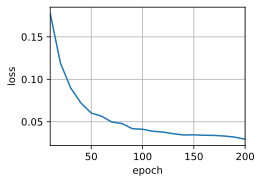

In [17]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10  # num_layers 指定 编码器层 和 解码器层 的数量
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用Transformer模型将一些英语句子翻译成法语，并且计算它们的BLEU分数。

In [18]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


### 编码器注意力可视化

**当进行最后一个英语到法语的句子翻译工作时，让我们可视化Transformer的注意力权重。**

编码器自注意力权重的形状为（编码器层数，注意力头数，`num_steps`或查询的数目，`num_steps`或“键－值”对的数目）。

In [19]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。接下来，将逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。

颜色越深代表权重越大。

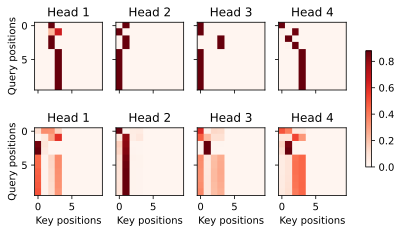

In [20]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

# 纵坐标代表 query，横坐标代表 key，颜色深浅代表权重值大小
# 有两行是因为有两个编码器层

### 解码器注意力可视化

为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。例如用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以*序列开始词元*（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。

In [23]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)

# 解码器自注意力权重；解码器交互注意力权重
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。

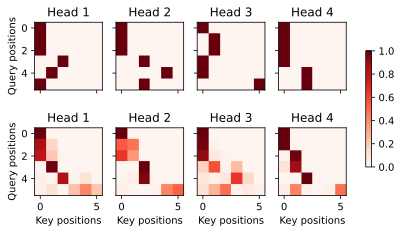

In [24]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

解码器交互注意力与编码器的自注意力的情况类似，通过指定输入序列的有效长度，输出序列的查询不会与输入序列中填充位置的词元进行注意力计算。

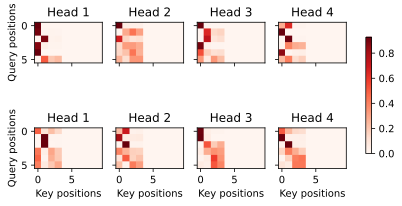

In [25]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

尽管Transformer架构是为了*序列到序列*的学习而提出的，但正如本书后面将提及的那样，Transformer编码器或Transformer解码器通常被单独用于不同的深度学习任务中。

## 小结

* Transformer是编码器－解码器架构的一个实践，尽管在实际情况中编码器或解码器可以单独使用。
* 在Transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留自回归属性。
* Transformer中的残差连接和层规范化是训练非常深度模型的重要工具。
* Transformer模型中基于位置的前馈网络使用同一个多层感知机，作用是对所有序列位置的表示进行转换。

## 练习

1. 在实验中训练更深的Transformer将如何影响训练速度和翻译效果？
2. 在Transformer中使用加性注意力取代缩放点积注意力是不是个好办法？为什么？
3. 对于语言模型，应该使用Transformer的编码器还是解码器，或者两者都用？如何设计？
4. 如果输入序列很长，Transformer会面临什么挑战？为什么？
5. 如何提高Transformer的计算速度和内存使用效率？提示：可以参考论文`Tay.Dehghani.Bahri.ea.2020`。
6. 如果不使用卷积神经网络，如何设计基于Transformer模型的图像分类任务？提示：可以参考Vision Transformer`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。

[Discussions](https://discuss.d2l.ai/t/5756)
